Import Libraries

https://jovian.ai/bnuratum/applying-cnn-on-chest-xray-images#C32

In [3]:
import os, sys, time, copy, glob, random
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn

import cv2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
parent_path = '/home/sysadm/Desktop/3ml/ZhangLabData/CellData/chest_xray'
train_dir = os.path.join(parent_path, 'train/')
valid_dir = os.path.join(parent_path, 'val/')
test_dir = os.path.join(parent_path, 'test/')

In [10]:
save_file_name = "vgg16-chest-4.pt"
checkpoint_path = "vgg16-chest-4.pth"

In [11]:
#Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [16]:
# Empty lists
categories = []
img_categories= []
n_train = []
n_valid = []
n_test = []
heights = []
widths= []

# Iterate through each category
for d in os.listdir(train_dir):
    if not d.startswith('.'):
        categories.append(d)

        # Number of each image
        train_images = os.listdir(train_dir  +  d)
        valid_images = os.listdir(valid_dir + d)
        test_images = os.listdir(test_dir + d)
    
        # Number of datasets
        n_train.append(len(train_images))
        n_valid.append(len(valid_images))
        n_test.append(len(test_images))

        # Find stats for train images
        for i in train_images:
             if not i.startswith('.'):
                img_categories.append(d)
                img = cv2.imread(train_dir + d + '/' + i)
                img_array = np.array(img)
                  
                # Shape
                heights.append(img_array.shape[0])
                widths.append(img_array.shape[1])

In [18]:
categories_df = pd.DataFrame({
    "category": categories,
    "n_train": n_train,
    "n_valid": n_valid,
    "n_test": n_test
})
categories_df.sort_values("category")

,category,n_train,n_valid,n_test
1,NORMAL,1200,149,235
0,PNEUMONIA,3722,162,390


In [17]:
image_df = pd.DataFrame({
    "category": img_categories,
    "height": heights,
    "width": widths
})

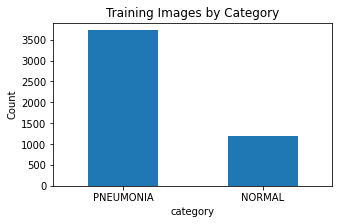

In [21]:
categories_df.set_index('category')['n_train'].plot.bar( figsize=(5, 3))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Training Images by Category');

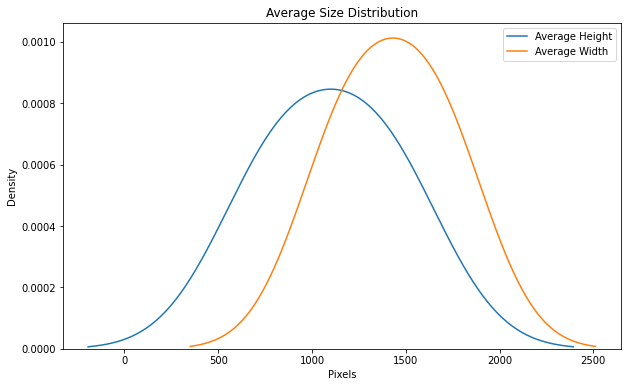

In [23]:
img_dsc = image_df.groupby("category").mean()
plt.figure(figsize=(10,6))
sns.kdeplot(img_dsc["height"],label="Average Height")
sns.kdeplot(img_dsc["width"],label="Average Width")
plt.xlabel("Pixels")
plt.ylabel("Density")
plt.title("Average Size Distribution")
plt.legend();

Define Transformation

In [2]:
# Here we use center crop size 224 and normalize mean vector [0.485, 0.456, 0.406],
# and standard deviation [0.229, 0.224, 0.225] for corresponding three channel (R,G,B)
# which are ImageNet standard augmentation technique parameter

transform_train = transforms.Compose([ 
    transforms.RandomResizedCrop(size =256, scale= (0.8, 1.0) ),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size =224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size =224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size =224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
])


Read the image path and class

In [3]:
# We only have train and test data folder. So, we separate some of the images from the train
# set and assign that as validation dataset.
parent_path = '/home/sysadm/Desktop/3ml/ZhangLabData/CellData/chest_xray'
train_paths = glob.glob(os.path.join(parent_path, 'train/*/*'))
train_class = [s.split('/')[-2] for s in train_paths]
test_paths = glob.glob(os.path.join(parent_path, 'test/*/*'))
test_class = [s.split('/')[-2] for s in test_paths]

In [4]:
train_paths, valid_paths, train_class, valid_class = train_test_split(train_paths, train_class, test_size=0.11)
print("\nTrain size: {}\nValid size: {}\nTest size: {}".format(len(train_paths), len(valid_paths), len(test_paths)))


Train size: 4656
Valid size: 576
Test size: 624


In [5]:
idx_to_class = {i:j for i, j in enumerate(train_class)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

Define Dataset Class

In [18]:
class ChestXRay(Dataset):
    def __init__(self, img_paths, transform=False):
        self.img_paths = img_paths
        self.transform = transform
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        label = img_path.split('/')[-2]
        label = class_to_idx[label]
        return img, label

Create Dataset

In [19]:
X_train = ChestXRay(train_paths, transform = transform_train)
X_valid = ChestXRay(valid_paths, transform = transform_valid)
X_test = ChestXRay(test_paths, transform = transform_test)

In [20]:
print('The shape of tensor for 50th image in train dataset: ',X_train[48][0].shape)
print('The label for 50th image in train dataset: ',X_train[48][1])

The shape of tensor for 50th image in train dataset:  (1492, 1778, 3)
The label for 50th image in train dataset:  4651


Define parameters and Dataloader

In [21]:
# Dictionary of parameters
params = {
#     "model": "resnet50",
#     "device": "cuda",
#     "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "n_epochs": 10,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 5
}

In [22]:
train_dataloader = DataLoader(X_train, batch_size = params['batch_size'], shuffle = True)
valid_dataloader = DataLoader(X_valid, batch_size = params['batch_size'], shuffle = True)
test_dataloader = DataLoader(X_test, batch_size = params['batch_size'], shuffle = True)
loaders = {'train': train_dataloader, 'valid': valid_dataloader, 'test': test_dataloader}

In [23]:
train_iter = iter(train_dataloader)
images, labels = next(train_iter)

print(images.shape)
print(labels.shape)

RuntimeError: stack expects each tensor to be equal size, but got [944, 1248, 3] at entry 0 and [1176, 1528, 3] at entry 1

In [18]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(432,288))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()
    
def show_batch_images(data_loader):
    images, labels = next(iter(data_loader))
    img = torchvision.utils.make_grid(images,padding=25)
    imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])


show_batch_images(train_dataloader)

RuntimeError: stack expects each tensor to be equal size, but got [728, 1152, 3] at entry 0 and [1480, 1882, 3] at entry 1

In [30]:
# Define CNN
class CNN(nn.Module):
    # Initialize the class
    def __init__(self):
        super(CNN, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)
    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

# Instantiate a CNN model
model = CNN()